# **BYU Locating Flagellar Motors - CUSTOMIZE IMPLEMENTATION**




In this notebook, we implement a custom Convolutional Neural Network (CNN) using PyTorch. We begin by preprocessing the data to ensure it is compatible with PyTorch’s format. Then, we perform a systematic exploration of different model configurations by tuning various hyperparameters to identify the most effective architecture. Finally, we select the best-performing model from our experiments to compare its performance against YOLO-based models.

## 1) Data Preprocessing


This pipeline prepares the tomograms data for a CNN using Pytorch package to detect the flagellar motors. Our goal is to have in our working directory all 

- Slice extraction and normalization
- Train/validation splitting
- Bounding box annotation
- Data augmentation
- YOLO-compatible dataset generation

In [ ]:
#package 
!pip install -U albumentations


In [4]:
#libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
import shutil
import time
import yaml
from pathlib import Path
from tqdm.notebook import tqdm 
import albumentations as A
import shutil
import os
import cv2
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import product
from torch.utils.data import Dataset, DataLoader


Before proceeding with the downstream analysis, we first need to clear all contents from the directory **/kaggle/working/**.

In [5]:

#path for kaggle working directory
working_dir = '/kaggle/working/'

#clean the directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    try:
        
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path) 
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')


This chunk of code sets up the environment and directory structure for training and validating a model. It begins by setting a random seed for reproducibility, defines the paths to the dataset and working directories, and creates subdirectories.It also sets key constants such as the number of adjacent slices to consider (TRUST), the size of bounding boxes around motors (BOX_SIZE), and the proportion of data used for training (TRAIN_SPLIT).

In [6]:
#set a seed
np.random.seed(456)

#path
data_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
train_dir = os.path.join(data_path, "train") # Extra data directory

#define the working dircetory for the train/validation
yolo_dataset_dir = "/kaggle/working/yolo_dataset"
yolo_images_train = os.path.join(yolo_dataset_dir, "images", "train")
yolo_images_val = os.path.join(yolo_dataset_dir, "images", "val")
yolo_labels_train = os.path.join(yolo_dataset_dir, "labels", "train")
yolo_labels_val = os.path.join(yolo_dataset_dir, "labels", "val")

for dir_path in [yolo_images_train, yolo_images_val, yolo_labels_train, yolo_labels_val]:
    os.makedirs(dir_path, exist_ok=True)

#CONSTANTS
TRUST = 0  # Number of slices above and below center slice (total 2*TRUST + 1 slices)
BOX_SIZE = 24  # Bounding box size for annotations (in pixels)
TRAIN_SPLIT = 0.8  # 80% for training, 20% for validation


This function **normalize_slice** performsnormalization on a tomographic image slice by clipping pixel values to the 2nd and 98th percentiles. This reduces the influence of outliers and enhances contrast. The clipped values are then linearly scaled to the range [0, 255] and converted to 8-bit unsigned integers, preparing the image for downstream processing or visualization.

In [7]:
def normalize_slice(slice_data):
    """
    Normalize pixels in slice data using 2nd and 98th percentiles
    """
    #use the percentiles
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    
    #clip the data
    clipped_data = np.clip(slice_data, p2, p98)
    
    #normalize the images [0, 255] range
    normalized = 255 * (clipped_data - p2) / (p98 - p2)
    
    return np.uint8(normalized)

The **compute_metrics** function calculates two basic statistical properties—mean and variance—of an image. It first ensures the image is in grayscale, then computes the mean and variance of pixel intensities. 

In [8]:
def compute_metrics(image):
    #convert the image into NUMPY ARRAY
    image_array = np.array(image)

    #convert to grayscale
    if len(image_array.shape) == 2 or (len(image_array.shape) == 3 and image_array.shape[2] == 1):
        gray = image_array
    else:
        gray = np.mean(image_array, axis=2)

    mean = np.mean(gray)
    var = np.var(gray)
    return mean, var

The **get_augmentation** function defines a sequence of data augmentation transformations. It randomly applies operations such as 90-degree rotations, horizontal and vertical flips, brightness and contrast adjustments, and Gaussian blur to enhance the diversity of the training dataset. 

In [9]:
def get_augmentation():
    return A.Compose([
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(blur_limit=(0,3), sigma_limit=(0.5,3), p=0.2),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

The function **prepare_yolo_dataset**, which creates a training and validation dataset tailored for YOLO-based object detection using tomographic image slices of bacterial flagellar motors. It starts by filtering for tomograms that contain exactly one motor, splits them into training and validation sets, and extracts slices centered around each motor. Each slice is normalized and filtered based on brightness and sharpness metrics. Annotations are generated in YOLO format, and optional data augmentation is applied to the training set. The final output is a dataset structured in the YOLO format, complete with a YAML configuration file ready for training.

In [10]:

def prepare_yolo_dataset(trust=TRUST, train_split=TRAIN_SPLIT, augment_factor: int=None):
    """
    Extract slices containing motors from tomograms and save to YOLO structure with annotations
    """
    #load the labels
    labels_df = pd.read_csv(os.path.join(data_path, "train_labels.csv"))
    
    #count the motors
    total_motors = labels_df['Number of motors'].sum()
    
    print(f"Total number of motors: {total_motors}")
    #take only the tomogams with only 1 motor
    tomo_df = labels_df[labels_df['Number of motors'] ==1].copy()
    unique_tomos = tomo_df['tomo_id'].unique()
    print(f"Found {len(unique_tomos)} unique tomograms with 1 motor")

    # train/val split
    np.random.shuffle(unique_tomos) 
    split_idx = int(len(unique_tomos) * train_split)
    train_tomos = unique_tomos[:split_idx]
    val_tomos = unique_tomos[split_idx:]
    print(f"Split: {len(train_tomos)} tomograms for training, {len(val_tomos)} tomograms for validation")

    #augmentation
    if augment_factor:
        augmenter = get_augmentation()

    #process th tomograms
    def process_tomogram_set(tomogram_ids, images_dir, labels_dir, set_name, augment=False):
        motor_counts = []
        for tomo_id in tomogram_ids:
            #take the motors
            tomo_motors = labels_df[labels_df['tomo_id'] == tomo_id]
            for _, motor in tomo_motors.iterrows():
                if pd.isna(motor['Motor axis 0']):
                    continue
                if (BOX_SIZE / 2 <= motor['Motor axis 1'] <= motor['Array shape (axis 1)'] - BOX_SIZE / 2 
                    and
                    BOX_SIZE / 2 <= motor['Motor axis 2'] <= motor['Array shape (axis 2)'] - BOX_SIZE / 2):
                    motor_counts.append(
                        (tomo_id, 
                         int(motor['Motor axis 0']), 
                         int(motor['Motor axis 1']), 
                         int(motor['Motor axis 2']),
                         int(motor['Array shape (axis 0)'])
                        )
                    )

        expected_slices = len(motor_counts) * (2 * trust + 1)
        if augment:
            expected_slices = expected_slices * (augment_factor + 1)  #original + augmented versions
        
        print(f"Will process approximately {expected_slices} slices for {set_name}")
        
        #process each motor
        processed_slices = 0
        
        for tomo_id, z_center, y_center, x_center, z_max in tqdm(motor_counts, desc=f"Processing {set_name} motors"):
            z_min = max(0, z_center - trust)
            z_max = min(z_max - 1, z_center + trust)
            
            #process each slice in the range
            for z in range(z_min, z_max + 1):
                #create  aslice file name 
                slice_filename = f"slice_{z:04d}.jpg"
                src_path = os.path.join(train_dir, tomo_id, slice_filename)
                if not os.path.exists(src_path):
                    print(f"Warning: {src_path} does not exist, skipping.")
                    continue
                    
                #load and normalize the data
                img = Image.open(src_path)
                img_width, img_height = img.size
                img_array = np.array(img)
                normalized_img = normalize_slice(img_array)
                mean, var = compute_metrics(Image.fromarray(normalized_img))

                #filter the data  mean brightness in [90, 180] and sharpness ≥ 200
                if not (90 <= mean <= 180 and var >= 200):
                    continue 
                
                #file destinations
                dest_filename = f"{tomo_id}_z{z:04d}_y{y_center:04d}_x{x_center:04d}.jpg"
                dest_path = os.path.join(images_dir, dest_filename)
                
                # Save the normalized image
                Image.fromarray(normalized_img).save(dest_path)
                #normalize between 0 and 1 
                x_center_norm = x_center / img_width
                y_center_norm = y_center / img_height
                box_width_norm = BOX_SIZE / img_width
                box_height_norm = BOX_SIZE / img_height
                
                #write label file
                label_path = os.path.join(labels_dir, dest_filename.replace('.jpg', '.txt'))
                with open(label_path, 'w') as f:
                    f.write(f"0 {x_center_norm} {y_center_norm} {box_width_norm} {box_height_norm}\n")
                
                processed_slices += 1

                if augment:
                    #augment * the nb of the augmenattionfactor
                    for aug_idx in range(augment_factor):
                        
                        if isinstance(normalized_img, Image.Image):
                            normalized_img = np.array(normalized_img)
                        #convert normalized to pixel for Albumentations
                        bbox_pixel = [x_center, y_center, BOX_SIZE, BOX_SIZE]  # x_center, y_center in pixels
                        bbox_yolo = [x_center_norm, y_center_norm, box_width_norm, box_height_norm]
                        
                        augmented= augmenter(image=normalized_img, 
                                             bboxes=[bbox_yolo], 
                                             class_labels=[0])

                        #retrieving augmented image and bounding box
                        aug_image = augmented['image']
                        aug_bbox = augmented['bboxes'][0]

                        x_center_norm_aug, y_center_norm_aug, _, _ = aug_bbox
                        x_center_aug = int(x_center_norm_aug * img_width)
                        y_center_aug = int(y_center_norm_aug * img_height)

                        #creat ethe file
                        aug_filename = f"{tomo_id}_z{z:04d}_y{y_center_aug:04d}_x{x_center_aug:04d}_aug{aug_idx}.jpg"
                        aug_path = os.path.join(images_dir, aug_filename)
                        
                        #save
                        Image.fromarray(aug_image).save(aug_path)

                        label_path = os.path.join(labels_dir, aug_filename.replace('.jpg', '.txt'))
                        with open(label_path, 'w') as f:
                            f.write(f"0 {x_center_norm_aug} {y_center_norm_aug} {box_width_norm} {box_height_norm}\n")
                            
                        processed_slices += 1
        
        return processed_slices, len(motor_counts)
    
    #process the training
    if augment_factor:
        train_slices, train_motors = process_tomogram_set(train_tomos, yolo_images_train, yolo_labels_train, "training", augment=True)
    else:
        train_slices, train_motors = process_tomogram_set(train_tomos, yolo_images_train, yolo_labels_train, "training")
    
    #process the validation
    val_slices, val_motors = process_tomogram_set(val_tomos, yolo_images_val, yolo_labels_val, "validation")
    
    #create the yaml file
    yaml_content = {
        'path': yolo_dataset_dir,
        'train': 'images/train',
        'val': 'images/val',
        'names': {0: 'motor'}
    }
    
    with open(os.path.join(yolo_dataset_dir, 'dataset.yaml'), 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)
    
    print(f"\nProcessing Summary:")
    print(f"- Train set: {len(train_tomos)} tomograms, {train_motors} motors, {train_slices} slices")
    print(f"- Validation set: {len(val_tomos)} tomograms, {val_motors} motors, {val_slices} slices")
    print(f"- Total: {len(train_tomos) + len(val_tomos)} tomograms, {train_motors + val_motors} motors, {train_slices + val_slices} slices")
    
    #summary
    return {
        "dataset_dir": yolo_dataset_dir,
        "yaml_path": os.path.join(yolo_dataset_dir, 'dataset.yaml'),
        "train_tomograms": len(train_tomos),
        "val_tomograms": len(val_tomos),
        "train_motors": train_motors,
        "val_motors": val_motors,
        "train_slices": train_slices,
        "val_slices": val_slices
    }

#run
summary = prepare_yolo_dataset(TRUST, augment_factor=3)
print(f"\nPreprocessing Complete:")
print(f"- Training data: {summary['train_tomograms']} tomograms, {summary['train_motors']} motors, {summary['train_slices']} slices")
print(f"- Validation data: {summary['val_tomograms']} tomograms, {summary['val_motors']} motors, {summary['val_slices']} slices")
print(f"- Dataset directory: {summary['dataset_dir']}")
print(f"- YAML configuration: {summary['yaml_path']}")
print(f"\nReady for YOLO training!")



Total number of motors: 831
Found 313 unique tomograms with 1 motor
Split: 250 tomograms for training, 63 tomograms for validation
Will process approximately 1000 slices for training


Processing training motors:   0%|          | 0/250 [00:00<?, ?it/s]

Will process approximately 63 slices for validation


Processing validation motors:   0%|          | 0/63 [00:00<?, ?it/s]


Processing Summary:
- Train set: 250 tomograms, 250 motors, 984 slices
- Validation set: 63 tomograms, 63 motors, 62 slices
- Total: 313 tomograms, 313 motors, 1046 slices

Preprocessing Complete:
- Training data: 250 tomograms, 250 motors, 984 slices
- Validation data: 63 tomograms, 63 motors, 62 slices
- Dataset directory: /kaggle/working/yolo_dataset
- YAML configuration: /kaggle/working/yolo_dataset/dataset.yaml

Ready for YOLO training!


The dataset preparation is complete: 313 tomograms with one motor each were processed, yielding 984 training slices and 62 validation slices. The data has been structured for YOLO training and saved to **/kaggle/working/yolo_dataset**, along with a configuration YAML file. The dataset is now ready for training.

In the next chunk of code , we loop over all the images to standardize them into the img_size that we want. 

In [11]:
img_size = (256,256,1)

#image directory
image_dir = Path('/kaggle/working/yolo_dataset/images/train')
output_size = (256, 256)

#loop over all the images
for image_path in image_dir.glob('*.jpg'):
    #read
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)   
    #resize
    resized_img = cv2.resize(img, output_size)
    #overwrite the currect image 
    cv2.imwrite(str(image_path), resized_img)

print("All images resized to 256x256.")


All images resized to 256x256.


In this part, we verify if the number of training labels and images that we have with the augmented data. 

In [5]:
#paths
images_path = '/kaggle/working/yolo_dataset/images/train'
labels_path = '/kaggle/working/yolo_dataset/labels/train'

# Count number of image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]

print(f"Number of image files: {len(image_files)}")
print(f"Number of label files: {len(label_files)}")


Number of image files: 984
Number of label files: 984


We have now 984 images and labes to work with, which is a decent size of dataset - in all of our slices we have one motor with the corresponding position. 

## 2)Training part

In the next code the function dataset returns image tensors along with normalized 2D coordinates of the motor centers as targets. The class reads images and labels from the specified directories, resizes and normalizes the images, and formats them for model input. The dataset is then split for both training and validation sets.

In [12]:
#function to return 2 tensors for pytorch
class MotorDatasetYOLO(Dataset):
    def __init__(self, image_dir, label_dir, img_size=(256, 256)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.image_filenames = sorted([
            fname for fname in os.listdir(image_dir) if fname.endswith(".jpg")
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        #join the labels with the images
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt"))

        #read the images
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  # (1, H, W)

        #read the labels 
        with open(label_path, 'r') as f:
            lines = f.readlines()

        #take the motor
        class_id, x_center, y_center, _, _ = map(float, lines[0].strip().split())
        target = np.array([x_center, y_center], dtype=np.float32)
        return torch.tensor(img), torch.tensor(target) #returns a tuple (image, target).
#The target is also converted into a PyTorch tensor

# path
TRAIN_IMG_DIR = '/kaggle/working/yolo_dataset/images/train'
TRAIN_LBL_DIR = '/kaggle/working/yolo_dataset/labels/train'
VAL_IMG_DIR = '/kaggle/working/yolo_dataset/images/val'
VAL_LBL_DIR = '/kaggle/working/yolo_dataset/labels/val'

#transform our data
train_dataset = MotorDatasetYOLO(image_dir=TRAIN_IMG_DIR, label_dir=TRAIN_LBL_DIR)
val_dataset = MotorDatasetYOLO(image_dir=VAL_IMG_DIR, label_dir=VAL_LBL_DIR)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

This code defines a dynamic convolutional neural network for regressing the 2D coordinates of motors in tomographic images. It dynamically builds a stack of convolutional layers followed by fully connected layers with dropout. The architecture adapts to the number of convolutional and dense layers specified by the user. The network takes 256×256 grayscale images as input and outputs two values: the normalized (x, y) coordinates of the motor center.

In [13]:
#dynamic cnn
class MotorRegressorCNN(nn.Module):
    def __init__(self, conv_layers=4, fc_layers=[256], dropout_rate=0.5):
        super().__init__()
        
        #build the layers
        layers = []
        in_channels = 1
        out_channels = 32
        
        for i in range(conv_layers):
            layers.extend([
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            ])
            in_channels = out_channels
            out_channels *= 2
        
        self.features = nn.Sequential(*layers)
        
        #calculate theflattened size 
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 256, 256)
            dummy_output = self.features(dummy_input)
            self.flattened_size = dummy_output.numel()

        #build the fully connected layers
        fc = []
        in_features = self.flattened_size
        
        for units in fc_layers:
            fc.extend([
                nn.Linear(in_features, units),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            in_features = units
        
        fc.append(nn.Linear(in_features, 2))  # Output x,y coordinates
        self.regressor = nn.Sequential(*fc)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.regressor(x)

In this chunk of code, we will perform a training with different parameters to explore how different architectural and training choices affect model performance in a CNN-based regression task. 
The parameters that we chose to hypertune are :
- the number of convolutional layers : We made the model vary between 3 or 4. It allows the model to see the difference on how deeper feature extraction influences the model’s ability to localize the bacterial flagellar motors. If then model has 3 CL it may only capture general patterns, while the one with 4 CL may extract more complex spatial features.
  
- The fully connected layer configurations :  We made the model vary between this 3 configurations[[256], [512], [256, 128]]. It can impact how well the network maps extracted features to coordinate outputs.

- The dropout rate : We made it vary between 0.3 and 0.5 - it helps evaluate regularization strength, reducing overfitting especially given the small target dimensionality.

- The learning rate : It varies between 0.0001 and 0.00001 which are standard for Adam optimizer and help balance convergence speed and stability. 



Testing combination 1:
Conv layers: 3, FC layers: [256], Dropout: 0.3, LR: 0.0001
Epoch 1/30:
  Train Loss: 0.0734
  Val Loss: 0.0471
Epoch 2/30:
  Train Loss: 0.0458
  Val Loss: 0.0419
Epoch 3/30:
  Train Loss: 0.0446
  Val Loss: 0.0377
Epoch 4/30:
  Train Loss: 0.0447
  Val Loss: 0.0419
Epoch 5/30:
  Train Loss: 0.0380
  Val Loss: 0.0348
Epoch 6/30:
  Train Loss: 0.0346
  Val Loss: 0.0373
Epoch 7/30:
  Train Loss: 0.0320
  Val Loss: 0.0365
Epoch 8/30:
  Train Loss: 0.0281
  Val Loss: 0.0351
Epoch 9/30:
  Train Loss: 0.0266
  Val Loss: 0.0367
Epoch 10/30:
  Train Loss: 0.0260
  Val Loss: 0.0372
Epoch 11/30:
  Train Loss: 0.0232
  Val Loss: 0.0383
Epoch 12/30:
  Train Loss: 0.0216
  Val Loss: 0.0398
Epoch 13/30:
  Train Loss: 0.0198
  Val Loss: 0.0408
Epoch 14/30:
  Train Loss: 0.0187
  Val Loss: 0.0383
Epoch 15/30:
  Train Loss: 0.0168
  Val Loss: 0.0384
Epoch 16/30:
  Train Loss: 0.0155
  Val Loss: 0.0444
Epoch 17/30:
  Train Loss: 0.0151
  Val Loss: 0.0456
Epoch 18/30:
  Train Loss

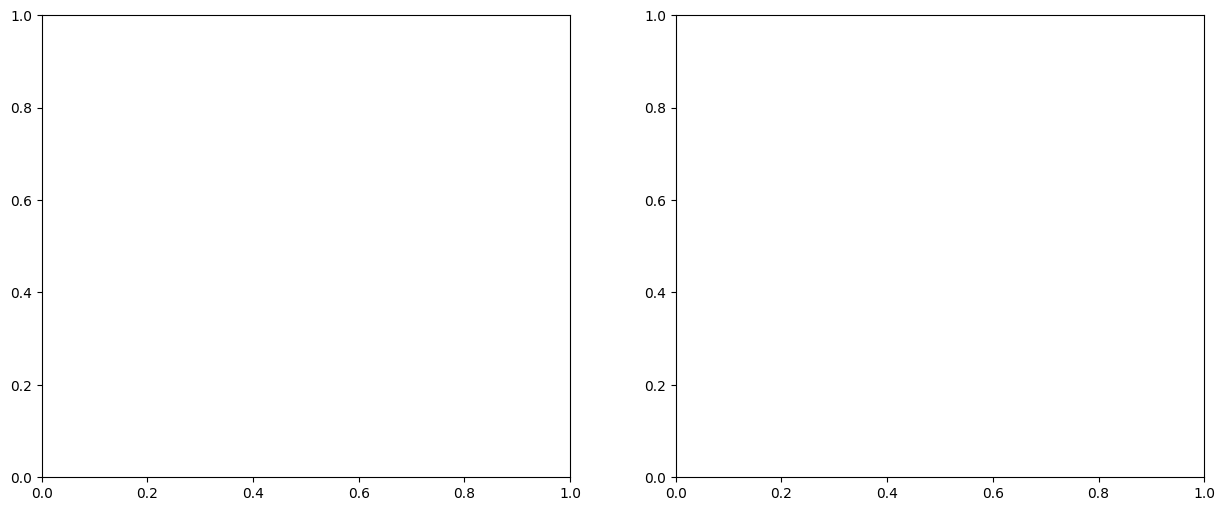

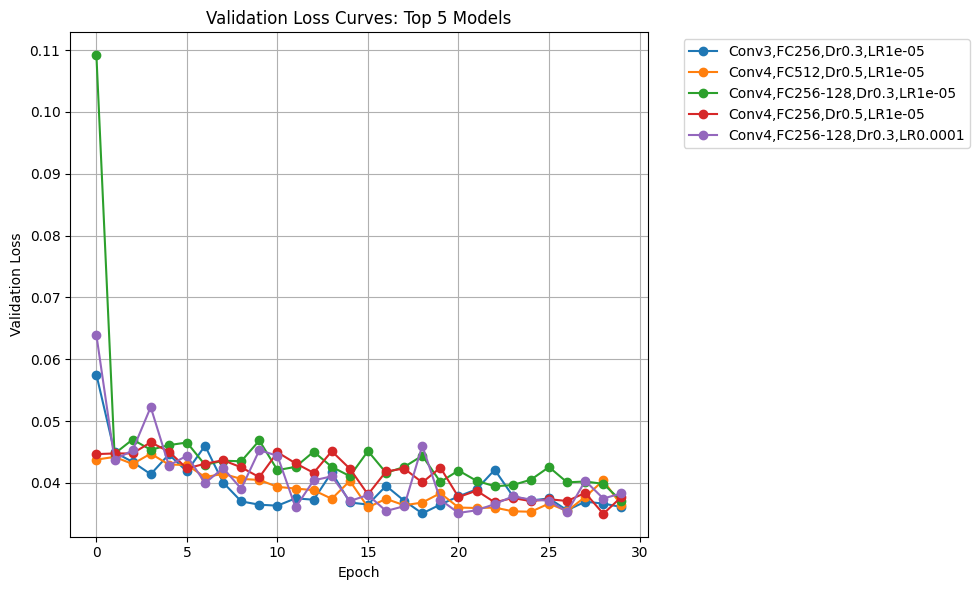

In [8]:
#training dfct
def train_model(model, train_dataloader, val_dataloader, epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'mse_x': [],
        'mse_y': []
    }
    
    for epoch in range(epochs):
        #train
        model.train()
        train_loss = 0
        for imgs, targets in train_dataloader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        #validation
        model.eval()
        val_loss = 0
        mse_x = 0
        mse_y = 0
        with torch.no_grad():
            for imgs, targets in val_dataloader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                
                val_loss += criterion(outputs, targets).item()
                mse_x += ((outputs[:, 0] - targets[:, 0]) ** 2).sum().item()
                mse_y += ((outputs[:, 1] - targets[:, 1]) ** 2).sum().item()
        
        #metrics
        history['train_loss'].append(train_loss / len(train_dataloader))
        history['val_loss'].append(val_loss / len(val_dataloader))
        history['mse_x'].append(mse_x / len(val_dataloader.dataset))
        history['mse_y'].append(mse_y / len(val_dataloader.dataset))
        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
        print(f"  Val Loss: {history['val_loss'][-1]:.4f}")
    
    return history

#parameters
param_grid = {
    'conv_layers': [3, 4],
    'fc_layers': [[256], [512], [256, 128]],
    'dropout_rate': [0.3, 0.5],
    'lr': [1e-4, 1e-5]
}

#stre the results
results = []

#run the experiments
for i, (conv_layers, fc_layers, dropout_rate, lr) in enumerate(product(*param_grid.values())):
    print(f"\nTesting combination {i+1}:")
    print(f"Conv layers: {conv_layers}, FC layers: {fc_layers}, Dropout: {dropout_rate}, LR: {lr}")
    
    model = MotorRegressorCNN(conv_layers=conv_layers,fc_layers=fc_layers,dropout_rate=dropout_rate)
    history = train_model(model,train_dataloader,val_dataloader,epochs=30,lr=lr)
    results.append({
        'params': (conv_layers, fc_layers, dropout_rate, lr),
        'history': history,
        'final_mse_x': history['mse_x'][-1],
        'final_mse_y': history['mse_y'][-1]
    })


#final avg mse 
for result in results:
    result['avg_final_mse'] = (result['final_mse_x'] + result['final_mse_y']) / 2
    result['final_val_loss'] = result['history']['val_loss'][-1]

#sort the mse
sorted_results = sorted(results, key=lambda x: x['avg_final_mse'])

#print the result
print("\nTop Performing Models (Sorted by Average Final MSE)")
print("="*85)
print("{:<5} {:<30} {:<15} {:<15} {:<15}".format(
    "Rank", "Configuration", "Val Loss", "MSE X", "MSE Y"))
print("-"*85)

for i, result in enumerate(sorted_results[:5]): 
    params = result['params']
    config = f"Conv{params[0]},FC{'-'.join(map(str, params[1]))},Dr{params[2]},LR{params[3]}"
    print("{:<5} {:<30} {:<15.4f} {:<15.4f} {:<15.4f}".format(
        i+1,
        config,
        result['final_val_loss'],
        result['final_mse_x'],
        result['final_mse_y']
    ))

#plot
plt.figure(figsize=(10, 6))
for i, result in enumerate(sorted_results[:5]):
    params = result['params']
    label = f"Conv{params[0]},FC{'-'.join(map(str, params[1]))},Dr{params[2]},LR{params[3]}"
    plt.plot(result['history']['val_loss'], 'o-', label=label)

plt.title('Validation Loss Curves: Top 5 Models - ADAM')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()




In this second experimental setup, we extended our original training pipeline by replacing the Adam optimizer with **Stochastic Gradient Descent (SGD)** to compare how different optimizers affect the model's ability to learn the regression task. While Adam is adaptive and often performs well out of the box, SGD with momentum can sometimes lead to better generalization. We removed some hyperparameters in order to run faster the code. We fixed the dropping rate at 0.3 and the size of fully convolutional at 256.

To account for the slower and more sensitive convergence behavior of SGD, we adjusted the learning rate range to higher values 0.001 and 0.0001 since SGD generally requires larger learning rates than Adam to make meaningful updates. 



Testing combination 1:
Conv layers: 3, FC layers: [256], Dropout: 0.3, LR: 0.001
Epoch 1/30:
  Train Loss: 0.0899
  Val Loss: 0.0469
Epoch 2/30:
  Train Loss: 0.0479
  Val Loss: 0.0445
Epoch 3/30:
  Train Loss: 0.0474
  Val Loss: 0.0465
Epoch 4/30:
  Train Loss: 0.0461
  Val Loss: 0.0442
Epoch 5/30:
  Train Loss: 0.0449
  Val Loss: 0.0445
Epoch 6/30:
  Train Loss: 0.0461
  Val Loss: 0.0450
Epoch 7/30:
  Train Loss: 0.0444
  Val Loss: 0.0452
Epoch 8/30:
  Train Loss: 0.0454
  Val Loss: 0.0449
Epoch 9/30:
  Train Loss: 0.0447
  Val Loss: 0.0450
Epoch 10/30:
  Train Loss: 0.0442
  Val Loss: 0.0446
Epoch 11/30:
  Train Loss: 0.0444
  Val Loss: 0.0433
Epoch 12/30:
  Train Loss: 0.0433
  Val Loss: 0.0440
Epoch 13/30:
  Train Loss: 0.0434
  Val Loss: 0.0435
Epoch 14/30:
  Train Loss: 0.0433
  Val Loss: 0.0422
Epoch 15/30:
  Train Loss: 0.0428
  Val Loss: 0.0425
Epoch 16/30:
  Train Loss: 0.0434
  Val Loss: 0.0429
Epoch 17/30:
  Train Loss: 0.0433
  Val Loss: 0.0430
Epoch 18/30:
  Train Loss:

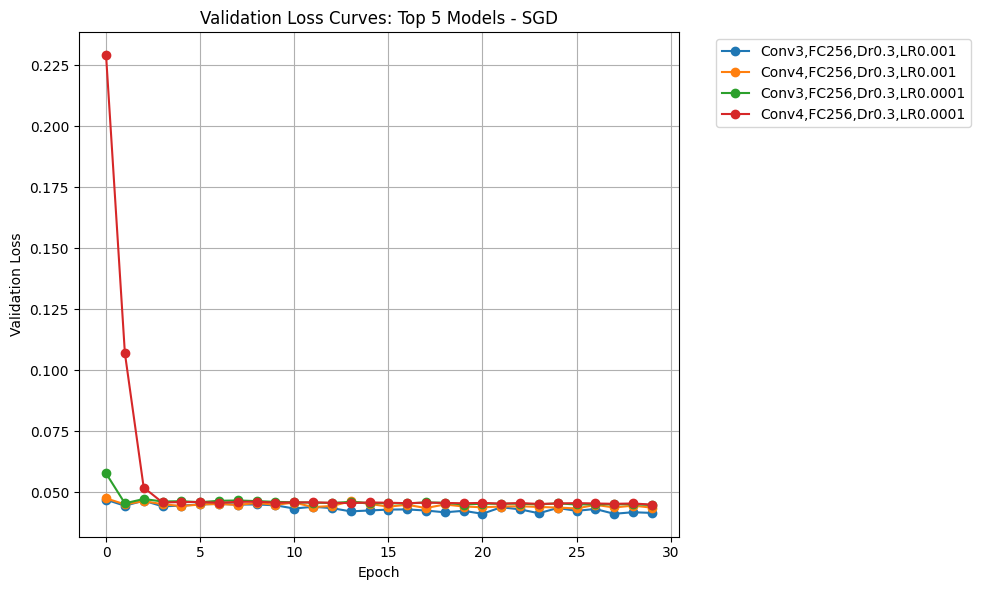

In [10]:

#train
def train_model(model, train_dataloader, val_dataloader, epochs=30, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.MSELoss()
    history = {
        'train_loss': [],
        'val_loss': [],
        'mse_x': [],
        'mse_y': []
    }
    
    for epoch in range(epochs):
        #train
        model.train()
        train_loss = 0
        for imgs, targets in train_dataloader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        #validate
        model.eval()
        val_loss = 0
        mse_x = 0
        mse_y = 0
        with torch.no_grad():
            for imgs, targets in val_dataloader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                
                val_loss += criterion(outputs, targets).item()
                mse_x += ((outputs[:, 0] - targets[:, 0]) ** 2).sum().item()
                mse_y += ((outputs[:, 1] - targets[:, 1]) ** 2).sum().item()
        
        #store the metrics
        history['train_loss'].append(train_loss / len(train_dataloader))
        history['val_loss'].append(val_loss / len(val_dataloader))
        history['mse_x'].append(mse_x / len(val_dataloader.dataset))
        history['mse_y'].append(mse_y / len(val_dataloader.dataset))
        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
        print(f"  Val Loss: {history['val_loss'][-1]:.4f}")

    return history

#same parameters
param_grid = {
    'conv_layers': [3, 4],
    'fc_layers': [[256]],
    'dropout_rate': [0.3],
    'lr': [1e-3, 1e-4]
}

#store the results
results2 = []

for i, (conv_layers, fc_layers, dropout_rate, lr) in enumerate(product(*param_grid.values())):
    print(f"\nTesting combination {i+1}:")
    print(f"Conv layers: {conv_layers}, FC layers: {fc_layers}, Dropout: {dropout_rate}, LR: {lr}")
    
    model = MotorRegressorCNN(conv_layers=conv_layers, fc_layers=fc_layers,dropout_rate=dropout_rate)
    history = train_model(model,train_dataloader,val_dataloader,epochs=30,lr=lr)
    
    results2.append({
        'params': (conv_layers, fc_layers, dropout_rate, lr),
        'history': history,
        'final_mse_x': history['mse_x'][-1],
        'final_mse_y': history['mse_y'][-1]
    })
    

#final avg mse 
for result in results2:
    result['avg_final_mse'] = (result['final_mse_x'] + result['final_mse_y']) / 2
    result['final_val_loss'] = result['history']['val_loss'][-1]

#sort the mse
sorted_results2 = sorted(results2, key=lambda x: x['avg_final_mse'])

#print the result
print("\nTop Performing Models (Sorted by Average Final MSE)")
print("="*85)
print("{:<5} {:<30} {:<15} {:<15} {:<15}".format(
    "Rank", "Configuration", "Val Loss", "MSE X", "MSE Y"))
print("-"*85)

for i, result in enumerate(sorted_results2[:5]): 
    params = result['params']
    config = f"Conv{params[0]},FC{'-'.join(map(str, params[1]))},Dr{params[2]},LR{params[3]}"
    print("{:<5} {:<30} {:<15.4f} {:<15.4f} {:<15.4f}".format(
        i+1,
        config,
        result['final_val_loss'],
        result['final_mse_x'],
        result['final_mse_y']
    ))

#plot
plt.figure(figsize=(10, 6))
for i, result in enumerate(sorted_results2[:5]):
    params = result['params']
    label = f"Conv{params[0]},FC{'-'.join(map(str, params[1]))},Dr{params[2]},LR{params[3]}"
    plt.plot(result['history']['val_loss'], 'o-', label=label)


plt.title('Validation Loss Curves: Top 5 Models - SGD')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In this final experiment, we train the model using **Stochastic Gradient Descent with momentum**, an optimization technique that enhances the basic SGD algorithm by accelerating convergence. The inclusion of momentum helps the optimizer navigate past small local minima and smooth out noisy gradients, increasing the likelihood of reaching a better global minimum more efficiently.



Testing combination 1:
Conv layers: 3, FC layers: [256], Dropout: 0.3, LR: 0.001
Epoch 1/30:
  Train Loss: 0.0723
  Val Loss: 0.0454
Epoch 2/30:
  Train Loss: 0.0467
  Val Loss: 0.0460
Epoch 3/30:
  Train Loss: 0.0466
  Val Loss: 0.0448
Epoch 4/30:
  Train Loss: 0.0467
  Val Loss: 0.0504
Epoch 5/30:
  Train Loss: 0.0443
  Val Loss: 0.0446
Epoch 6/30:
  Train Loss: 0.0454
  Val Loss: 0.0439
Epoch 7/30:
  Train Loss: 0.0452
  Val Loss: 0.0449
Epoch 8/30:
  Train Loss: 0.0449
  Val Loss: 0.0435
Epoch 9/30:
  Train Loss: 0.0449
  Val Loss: 0.0429
Epoch 10/30:
  Train Loss: 0.0438
  Val Loss: 0.0441
Epoch 11/30:
  Train Loss: 0.0447
  Val Loss: 0.0430
Epoch 12/30:
  Train Loss: 0.0450
  Val Loss: 0.0429
Epoch 13/30:
  Train Loss: 0.0437
  Val Loss: 0.0430
Epoch 14/30:
  Train Loss: 0.0441
  Val Loss: 0.0437
Epoch 15/30:
  Train Loss: 0.0434
  Val Loss: 0.0423
Epoch 16/30:
  Train Loss: 0.0444
  Val Loss: 0.0429
Epoch 17/30:
  Train Loss: 0.0421
  Val Loss: 0.0435
Epoch 18/30:
  Train Loss:

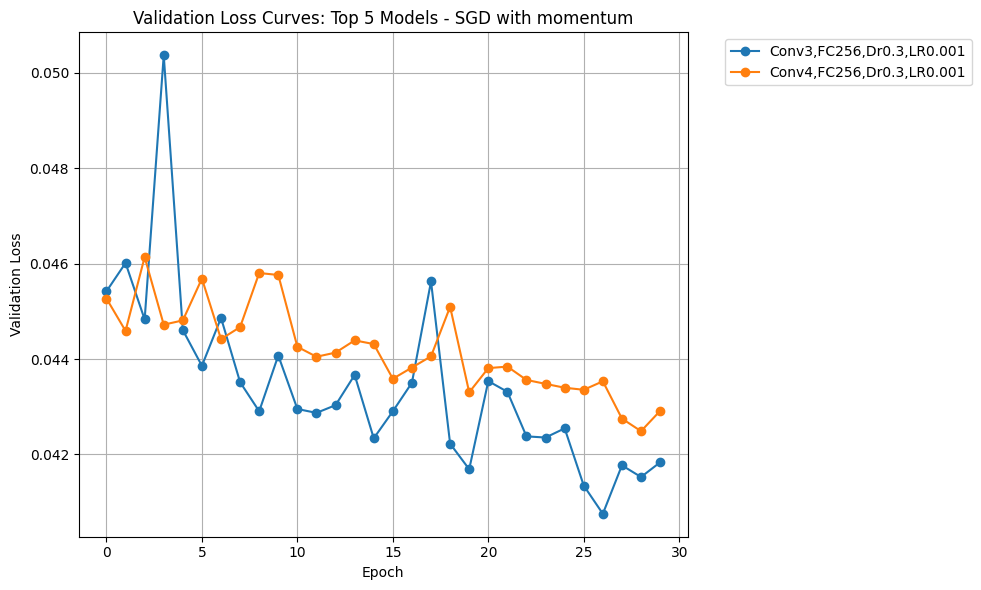

In [59]:

#train
def train_model(model, train_dataloader, val_dataloader, epochs=30, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov = True)
    criterion = nn.MSELoss()
    history = {
        'train_loss': [],
        'val_loss': [],
        'mse_x': [],
        'mse_y': []
    }
    
    for epoch in range(epochs):
        #train
        model.train()
        train_loss = 0
        for imgs, targets in train_dataloader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        #validate
        model.eval()
        val_loss = 0
        mse_x = 0
        mse_y = 0
        with torch.no_grad():
            for imgs, targets in val_dataloader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                
                val_loss += criterion(outputs, targets).item()
                mse_x += ((outputs[:, 0] - targets[:, 0]) ** 2).sum().item()
                mse_y += ((outputs[:, 1] - targets[:, 1]) ** 2).sum().item()
        
        #store the metrics
        history['train_loss'].append(train_loss / len(train_dataloader))
        history['val_loss'].append(val_loss / len(val_dataloader))
        history['mse_x'].append(mse_x / len(val_dataloader.dataset))
        history['mse_y'].append(mse_y / len(val_dataloader.dataset))
        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
        print(f"  Val Loss: {history['val_loss'][-1]:.4f}")

    return history

param_grid = {
    'conv_layers': [3, 4],
    'fc_layers': [[256]],
    'dropout_rate': [0.3],
    'lr': [1e-3]
}


#store the results
results3 = []

for i, (conv_layers, fc_layers, dropout_rate, lr) in enumerate(product(*param_grid.values())):
    print(f"\nTesting combination {i+1}:")
    print(f"Conv layers: {conv_layers}, FC layers: {fc_layers}, Dropout: {dropout_rate}, LR: {lr}")
    
    model = MotorRegressorCNN(conv_layers=conv_layers, fc_layers=fc_layers,dropout_rate=dropout_rate)
    history = train_model(model,train_dataloader,val_dataloader,epochs=30,lr=lr)
    
    results3.append({
        'params': (conv_layers, fc_layers, dropout_rate, lr),
        'history': history,
        'final_mse_x': history['mse_x'][-1],
        'final_mse_y': history['mse_y'][-1]
    })
    

#final avg mse 
for result in results3:
    result['avg_final_mse'] = (result['final_mse_x'] + result['final_mse_y']) / 2
    result['final_val_loss'] = result['history']['val_loss'][-1]

#sort the mse
sorted_results3 = sorted(results3, key=lambda x: x['avg_final_mse'])

#print the result
print("\nTop Performing Models (Sorted by Average Final MSE)")
print("="*85)
print("{:<5} {:<30} {:<15} {:<15} {:<15}".format(
    "Rank", "Configuration", "Val Loss", "MSE X", "MSE Y"))
print("-"*85)

for i, result in enumerate(sorted_results3[:5]): 
    params = result['params']
    config = f"Conv{params[0]},FC{'-'.join(map(str, params[1]))},Dr{params[2]},LR{params[3]}"
    print("{:<5} {:<30} {:<15.4f} {:<15.4f} {:<15.4f}".format(
        i+1,
        config,
        result['final_val_loss'],
        result['final_mse_x'],
        result['final_mse_y']
    ))

#plot
plt.figure(figsize=(10, 6))
for i, result in enumerate(sorted_results3[:5]):
    params = result['params']
    label = f"Conv{params[0]},FC{'-'.join(map(str, params[1]))},Dr{params[2]},LR{params[3]}"
    plt.plot(result['history']['val_loss'], 'o-', label=label)

plt.title('Validation Loss Curves: Top 5 Models - SGD with momentum')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


The dynamic CNN architecture demonstrated strong performance across various configurations, particularly when combined with the Adam optimizer. Among the tested setups, the configuration with 3 convolutional layers, a single fully connected layer of 256 units, dropout of 0.3, and a learning rate of 0.00001 achieved the lowest validation loss (0.0361) and balanced mean squared errors for both X and Y predictions.

Overall, models trained with **Adam** consistently outperformed those trained with **SGD** and **SGD with momentum** achieving lower validation losses and better coordinate accuracy. This highlights Adam's effectiveness in handling the complex optimization landscape of deep networks.

The architecture's flexibility in the number of convolutional and fully connected layers, along with adjustable dropout, proved useful in tailoring the model's capacity to the task. This modular design, combined with careful hyperparameter tuning, led to accurate and robust regression performance for predicting 2D motor positions.


## 3) Final model


Testing combination 1:
Conv layers: 3, FC layers: [256], Dropout: 0.3, LR: 1e-05
  Avg Euclidean Distance: 0.2870
Epoch 1/30:
  Train Loss: 0.0810
  Val Loss: 0.0501
  Avg Euclidean Distance: 0.2627
Epoch 2/30:
  Train Loss: 0.0497
  Val Loss: 0.0438
  Avg Euclidean Distance: 0.2693
Epoch 3/30:
  Train Loss: 0.0462
  Val Loss: 0.0453
  Avg Euclidean Distance: 0.2540
Epoch 4/30:
  Train Loss: 0.0450
  Val Loss: 0.0413
  Avg Euclidean Distance: 0.2512
Epoch 5/30:
  Train Loss: 0.0452
  Val Loss: 0.0403
  Avg Euclidean Distance: 0.2551
Epoch 6/30:
  Train Loss: 0.0420
  Val Loss: 0.0409
  Avg Euclidean Distance: 0.2595
Epoch 7/30:
  Train Loss: 0.0426
  Val Loss: 0.0418
  Avg Euclidean Distance: 0.2416
Epoch 8/30:
  Train Loss: 0.0406
  Val Loss: 0.0375
  Avg Euclidean Distance: 0.2425
Epoch 9/30:
  Train Loss: 0.0397
  Val Loss: 0.0374
  Avg Euclidean Distance: 0.2410
Epoch 10/30:
  Train Loss: 0.0385
  Val Loss: 0.0370
  Avg Euclidean Distance: 0.2394
Epoch 11/30:
  Train Loss: 0.0385


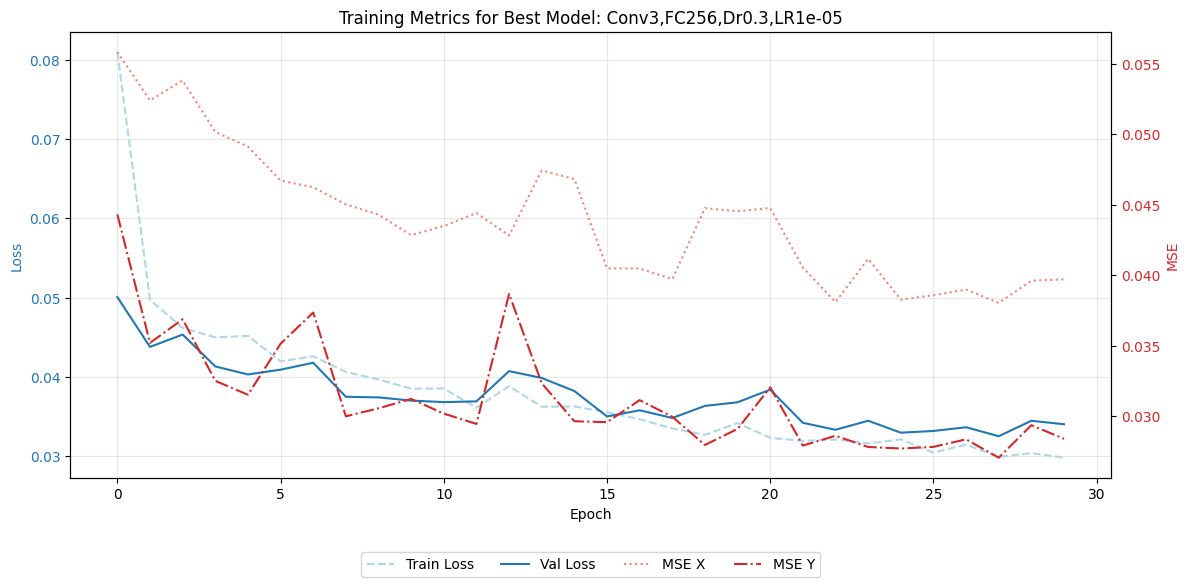

In [21]:
#training model
def train_model(model, train_dataloader, val_dataloader, epochs=30, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Fixed: use the passed lr parameter
    criterion = nn.MSELoss()
    history = {
        'train_loss': [],
        'val_loss': [],
        'mse_x': [],
        'mse_y': [],
        'euclidean_dist':[]
    }
    
    for epoch in range(epochs):
        #train
        model.train()
        train_loss = 0
        for imgs, targets in train_dataloader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        #validate
        model.eval()
        val_loss = 0
        mse_x = 0
        mse_y = 0
        euclidean_dist=0
        with torch.no_grad():
            for imgs, targets in val_dataloader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, targets).item()
                mse_x += ((outputs[:, 0] - targets[:, 0]) ** 2).sum().item()
                mse_y += ((outputs[:, 1] - targets[:, 1]) ** 2).sum().item()
                euclidean_dist += torch.norm(outputs - targets, dim=1).sum().item()

        
        #store
        avg_euclidean = euclidean_dist / len(val_dataloader.dataset)
        history['train_loss'].append(train_loss / len(train_dataloader))
        history['val_loss'].append(val_loss / len(val_dataloader))
        history['mse_x'].append(mse_x / len(val_dataloader.dataset))
        history['mse_y'].append(mse_y / len(val_dataloader.dataset))
        history['euclidean_dist'].append(avg_euclidean)
        avg_euclidean = euclidean_dist / len(val_dataloader.dataset)
        print(f"  Avg Euclidean Distance: {avg_euclidean:.4f}")

        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
        print(f"  Val Loss: {history['val_loss'][-1]:.4f}")

    return history

#our final parameters
param_grid = {
    'conv_layers': [3],
    'fc_layers': [[256]],
    'dropout_rate': [0.3],
    'lr': [1e-5]
}


results = []
#train
for i, (conv_layers, fc_layers, dropout_rate, lr) in enumerate(product(*param_grid.values())):
    print(f"\nTesting combination {i+1}:")
    print(f"Conv layers: {conv_layers}, FC layers: {fc_layers}, Dropout: {dropout_rate}, LR: {lr}")
    
    model = MotorRegressorCNN(conv_layers=conv_layers, fc_layers=fc_layers, dropout_rate=dropout_rate)
    history= train_model(model, train_dataloader, val_dataloader, epochs=30, lr=lr)
    
    results.append({
        'params': (conv_layers, fc_layers, dropout_rate, lr),
        'history': history,
        'final_mse_x': history['mse_x'][-1],
        'final_mse_y': history['mse_y'][-1],
        'final_val_loss': history['val_loss'][-1], # Added for completeness
        'euclidean_dist' : history['euclidean_dist'][-1]
    })

#
sorted_results = sorted(results, key=lambda x: x['final_mse_x'])
#print(f"The final MSEy is {sorted_results['final_mse_y']}")
#print(f"The final MSEx is {sorted_results['final_mse_x']}")
#print(f"The final euclidean distance is {sorted_results['euclidean_dist']}")

#plot the best model
if len(sorted_results) > 0:
    best_result = sorted_results[0]  # Get best model based on MSE X
    params = best_result['params']  # Fixed typo: was best_r
    
    #figure
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    #y axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(best_result['history']['train_loss'], '--', color='lightblue', label='Train Loss')
    ax1.plot(best_result['history']['val_loss'], '-', color='tab:blue', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)
    
    #y2 axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('MSE', color='tab:red')
    ax2.plot(best_result['history']['mse_x'], ':', color='salmon', label='MSE X')
    ax2.plot(best_result['history']['mse_y'], '-.', color='tab:red', label='MSE Y')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    #legends
    lines, labels = [], []
    for ax in [ax1, ax2]:
        line, label = ax.get_legend_handles_labels()
        lines.extend(line)
        labels.extend(label)
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    
    plt.title(f'Training Metrics for Best Model: Conv{params[0]},FC{"-".join(map(str, params[1]))},Dr{params[2]},LR{params[3]}')
    fig.tight_layout()
    plt.show()
else:
    print("No results to plot!")

In this part, we will predict and the points on the validation dataset. We need that to calculate the euclidean distance. 

In [60]:
def predict_and_compare(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    predictions = []
    targets_list = []
    
    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            predictions.append(outputs.cpu())
            targets_list.append(targets)
    
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets_list, dim=0)
    
    return predictions, targets
preds, targets = predict_and_compare(model, val_dataloader)
#vizualize a few results
for i in range(5):
    print(f"Predicted: {preds[i].numpy()}, Target: {targets[i].numpy()}")

Predicted: [0.54147035 0.5164905 ], Target: [0.66810346 0.90093845]
Predicted: [0.51381445 0.46425873], Target: [0.18642241 0.26277372]
Predicted: [0.54170144 0.5302737 ], Target: [0.20689656 0.71875   ]
Predicted: [0.4809659 0.4306477], Target: [0.53556037 0.503125  ]
Predicted: [0.5319977 0.5412143], Target: [0.38362068 0.71458334]


In this part, we will compute th euclidean distance in order ot compare the model with the other metrics.

## 4) Vizualization

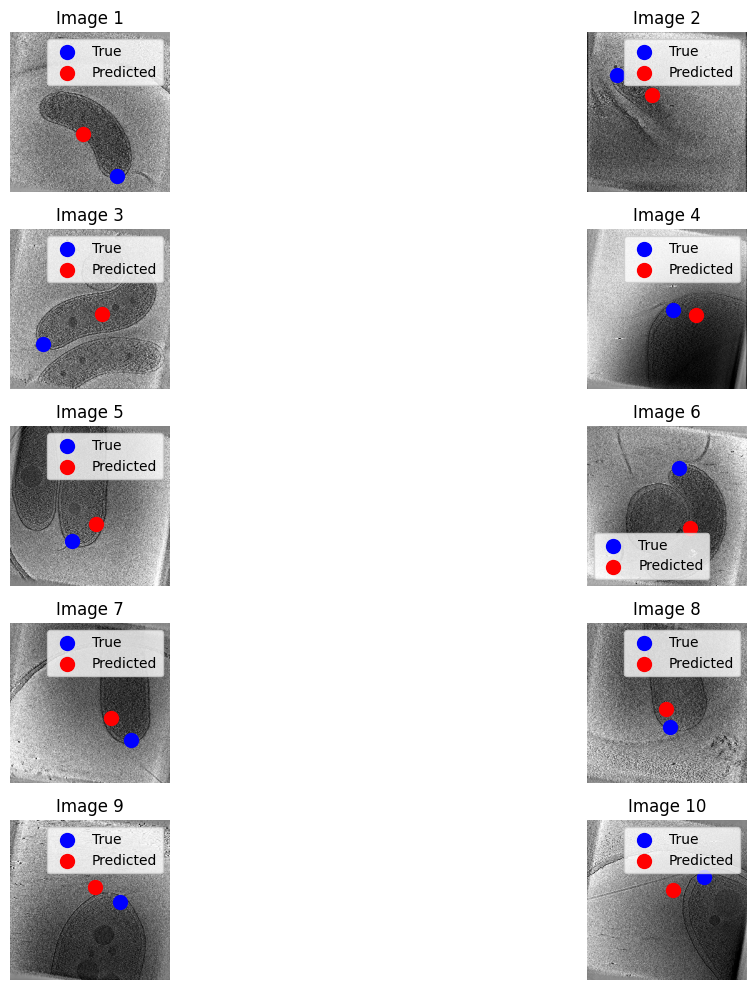

In [58]:

def plot_predictions(model, val_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    fig, axes = plt.subplots(5, 2, figsize=(16,10))
    axes = axes.flatten()

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(val_dataloader):
            if  i >=10:  # Only plot the first 10 images
                break

            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            img = imgs[0].cpu().numpy() 
            preds = preds.cpu().numpy()  #predictions
            targets = targets.cpu().numpy()  #true values
            img = img[0]  #take the first channel (grayscale image)

            ax = axes[i]
            ax.imshow(img, cmap='gray')
            ax.scatter(targets[0][0] * img.shape[1], targets[0][1] * img.shape[0], color='blue', label="True", s=100)  # True point
            ax.scatter(preds[0][0] * img.shape[1], preds[0][1] * img.shape[0], color='red', label="Predicted", s=100)  # Predicted point
            ax.set_title(f"Image {i+1}")
            ax.axis('off')
            ax.legend()

    plt.tight_layout()
    plt.show()

#calling of the function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plot_predictions(model, val_dataloader, device)
